In [21]:
import sys  
sys.path.insert(0, '../search-engine')
from utils import *
import pandas as pd
from scipy.stats import spearmanr

# NB2: Output Diversification

## 0. Import data
Import data from search engine and clustering from NB1: Output Analysis

In [3]:
# Import data and work with a sample of size 10000
data = get_tweets(None, None, mode = "read", data_directory = '../data/')
data = data[:10000]

# Create tweetsDict, inverted index and tf, df, idf for each term of the sample data
tweetsDict = create_tweets_dict(data)
index, tf, df, idf = create_index_tfidf(data, len(data))

In [8]:
# Import clustering resulting from NB1 (QR1)
cluster_df = pd.read_csv("../other-outputs/clustering_output_10000.csv", index_col = "Unnamed: 0")
cluster_df.head()

,Text,Cluster
1335568906937896960,RT @9NEWSNANCY: 🤬@SpeakerPelosi has a LOT of d...,2
1335568907059466241,The Canadian strikes again https://t.co/Wj2i8L...,2
1335568907059535874,Call your legislators! #FightForTrump https://...,0
1335568907139231744,RT @BernardKerik: These are the four cowardice...,2
1335568907311132674,RT @realDonaldTrump: The answer to the Democra...,0


<font color = "DarkGreen">
    
## All following steps are related to a specific **query** and the **top-k**.  Specify them in the following cell:
</font>

In [31]:
query = "Trump"
topk = 10

## 1. Compute scores

Compute scores for specified query (tf-idf, personalized and w2v)

In [9]:
scores = personalized_rank(query, index, tf, idf, tweetsDict, data)
scores.head()

,tf-idf,partial,personalized,w2v
1335568907311206400,0.432033,0.000111,0.432083,38.032317
1335568907411869698,0.379019,0.004974,0.381285,66.773098
1335568908481335297,0.379019,0.000005,0.379021,59.197474
1335568908812759040,0.394459,0.000073,0.394492,77.436772
1335568909072785411,0.507454,0.000009,0.507458,45.645381
...,...,...,...,...
1335563686803542018,0.411948,0.002139,0.412922,54.764674
1335563687311060999,0.483133,0.000245,0.483245,69.506792
1335563687453712390,0.411948,0.001637,0.412693,65.371779
1335563687935897602,0.411948,0.000645,0.412242,54.274665


In [10]:
# Append clusters to scores results
scores.index = scores.index.astype('int64')
scores = scores.join(cluster_df, how= "left")
scores.head()

,tf-idf,partial,personalized,w2v,Text,Cluster
1335568907311206400,0.432033,0.000111,0.432083,38.032317,@SoCal_For_Life @DanScavino That’s disgusting....,0
1335568907411869698,0.379019,0.004974,0.381285,66.773098,RT @smalltownandrew: Donald Trump Demands Vote...,0
1335568908481335297,0.379019,0.000005,0.379021,59.197474,RT @mmpadellan: trump just told his Valdosta c...,0
1335568908812759040,0.394459,0.000073,0.394492,77.436772,RT @realDonaldTrump: ***Live Updates*** Trump ...,0
1335568909072785411,0.507454,0.000009,0.507458,45.645381,@petercbarbour @JennaEllisEsq No. That 2 minut...,2


## 3. Diversity score
Diversity score aggregates a partial score to the tf-idf score, therefore, it has to be computed with respect to a certain query

\begin{equation*} \mathbf{diversity\_score = tfidf + \lambda * partial\_score} \end{equation*}
Where: 

- $\lambda = 1/3 * max(tfidf)$ regulating the impact on the score 

- $ partial\_score = 1 - \frac{cluster\_size}{total\_size}$

In [14]:
# Compute diversity score
div_score = []
lamb = 1/3
clusters_size = scores.Cluster.value_counts()
max_tfidf = scores["tf-idf"].max(axis=0)
for i, value in scores.iterrows():
    partial = 1 - clusters_size[value["Cluster"]]/len(scores)
    score = value["tf-idf"] + lamb * max_tfidf * partial
    div_score.append(score)
    
# Add it to scores dataFrame
scores["diversity"] = div_score

## 4. Visualize the impact of the diversity score 

See tf-idf and diversity score for the test query:

In [34]:
scores[["tf-idf", "diversity", "Cluster"]].head()

,tf-idf,diversity,Cluster
1335568907311206400,0.432033,0.550327,0
1335568907411869698,0.379019,0.497314,0
1335568908481335297,0.379019,0.497314,0
1335568908812759040,0.394459,0.512753,0
1335568909072785411,0.507454,0.844602,2


Display top-5 results sorting by both scores

In [35]:
display_ranking(scores, tweetsDict, query, score = "tf-idf", top_k = topk)


Top-10 documents sorted by tf-idf score
1335559283564453889: 🇺🇸trump https://t.co/P3ctsnhebv

1335565393147080710: *with Trump

1335568968795516928: RT @BeNosey: UK HERE, I TOTALLY GET TRUMP #TRUMP https://t.co/COZIUWFFn6

1335568930216300544: RT @JoyAnnReid: Nixon was the Trump before Trump.

1335567431499051010: @ANINewsUP @ANI If they are farmer than i am #Trump

1335571192569270274: @WarrenWhitlock Except #Trump maybe ? :-)

1335571398287368192: #Trump is such a #Creep

1335567817530171392: RT @Pollyanna1698: Trump Won!!! https://t.co/EFuNGXJhRb

1335572554698911744: Trump card https://t.co/JpF6FuaiS8

1335559313788727302: Trump Nation! https://t.co/Akjs7PFhRW



In [36]:
display_ranking(scores, tweetsDict, query, score = "diversity", top_k = topk)


Top-10 documents sorted by diversity score
1335559283564453889: 🇺🇸trump https://t.co/P3ctsnhebv

1335565393147080710: *with Trump

1335567431499051010: @ANINewsUP @ANI If they are farmer than i am #Trump

1335572554615033857: @TheDemCoalition @BuzzFeedNews How about #Trump revealing his taxes?

1335568968795516928: RT @BeNosey: UK HERE, I TOTALLY GET TRUMP #TRUMP https://t.co/COZIUWFFn6

1335568930216300544: RT @JoyAnnReid: Nixon was the Trump before Trump.

1335559344113520640: RT @BeNosey: Numbers. 17 / 9+1+7 17=Q. #TRUMP https://t.co/nkK6aoUBLP https://t.co/b1VMhnk0gy https://t.co/zE4DA0hCM8 https://t.co/HWC8s…

1335571192569270274: @WarrenWhitlock Except #Trump maybe ? :-)

1335571458194542593: A trump fart in action. https://t.co/qomCcGqdCM

1335571179000754177: @ScottFishman TRUMP



## 5. Coverage and ranking difference

Compute **correlation coefficient** between original (tf-idf score) and diversity score

In [24]:
coef, p = spearmanr(scores["tf-idf"], scores["diversity"])
print("Correlation coefficient betweet tf-idf and diversity scores: {}". format(round(coef, 3)))

Correlation coefficient betweet tf-idf and diversity scores: 0.661


Compute **coverage** for both scores

In [54]:
def plot_coverage(df, score, topk):
    clusters = df.sort_values(by = score, ascending = False)[:topk]["Cluster"]
    fig = plt.figure(figsize=(20,5))
    clusters.value_counts().plot(kind = "barh", color = "lightblue")
    plt.xlabel("Count in top-{}".format(topk), fontsize=15)
    plt.ylabel("Clusters", fontsize=15)
    plt.title("Clusters coverage using {} score".format(score), fontsize = 20)
    

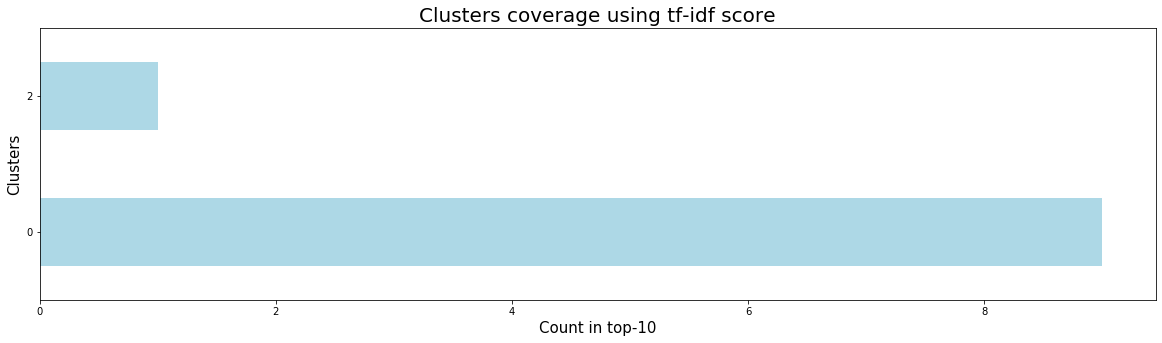

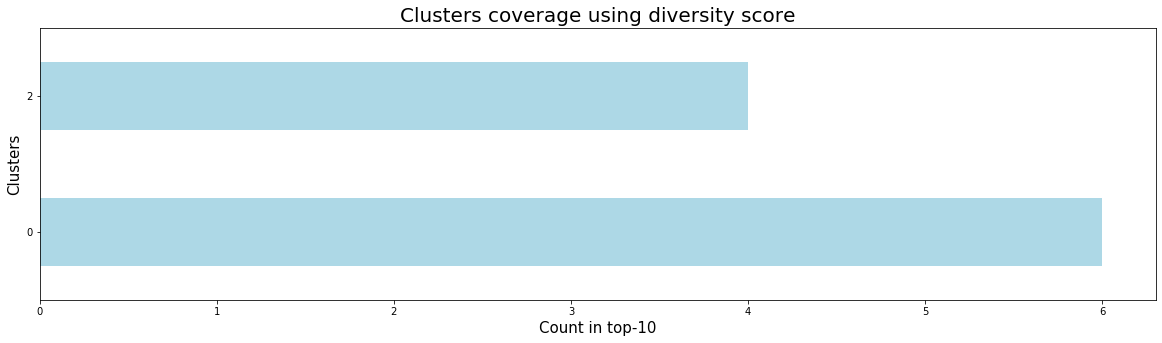

In [57]:
plot_coverage(scores, "tf-idf", topk)
plot_coverage(scores, "diversity", topk)